In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tssb.utils import load_time_series_segmentation_datasets
from tssb.evaluation import covering

In [3]:
# loading datasets
tssb = load_time_series_segmentation_datasets() 
# names=["ArrowHead", "InsectWingbeatSound", "TwoLeadECG"]
tssb.shape

(75, 4)

In [4]:
tssb.head(10)

,dataset,window_size,change_points,time_series
0,Adiac,10,"[572, 1012, 1232]","[1.681146, 1.383394, 1.029389, 0.688386, 0.354..."
1,ArrowHead,10,[753],"[-1.957721, -1.858082, -1.657983, -1.420794, -..."
2,Beef,50,[705],"[-0.380818, -0.352238, -0.295392, -0.225041, -..."
3,BeetleFly,10,[1280],"[1.114805, 0.774403, 0.477129, 0.115781, -0.24..."
4,BirdChicken,20,[1280],"[1.697714, 1.439032, 1.22287, 0.99708, 0.76479..."
5,Car,20,"[577, 1154, 1550]","[1.451648, 1.030174, 0.531853, 0.040229, -0.40..."
6,CBF,20,"[384, 704]","[-1.27713, -0.689811, -0.901181, -0.937038, -0..."
7,Chinatown,10,[],"[0.025935, -0.435655, -0.608168, -0.81565, -1...."
8,ChlorineConcentration,10,[2365],"[2.496227, 1.046743, 0.391124, 0.607525, -0.22..."
9,CinCECGTorso,10,"[2663, 5121]","[-0.118215, -0.115326, -0.111855, -0.1229, -0...."


In [5]:
from CLaSP import CLaSP
from copy import deepcopy

In [6]:
# for i in range(75):
#     name = tssb.iloc[i,::]['dataset']
#     wind_size = tssb.iloc[i,::]['window_size']
#     true_chp = tssb.iloc[i,::]['change_points']      
#     time_series = tssb.iloc[i,::]['time_series'] 
#     if time_series.shape[0] > 4500:
#         continue
#     print(name, ' ', len(time_series), ' ', len(true_chp))

In [ ]:
res_knn = {}
for i in range(tssb.shape[0]):
    name = tssb.iloc[i,::]['dataset']
    wind_size = tssb.iloc[i,::]['window_size']
    true_chp = tssb.iloc[i,::]['change_points']      
    time_series = tssb.iloc[i,::]['time_series']  
    if time_series.shape[0] > 4500:
        continue
    
    cls = CLaSP(window=4, solver='knn') #wind_size
    cls.fit(time_series[::2], n_segments=len(true_chp)+1)
    
    numbers = set()
    for elem in cls.stack:
        numbers.add(elem['start'])
        numbers.add(elem['stop'])    
    res_knn[name] = np.array(sorted(list(numbers))[1:-1])*2
    print(name)
    print('true: ',true_chp)
    print('pred: ',np.array(sorted(list(numbers))[1:-1])*2)
    print('='*100)

In [ ]:
# import pickle
# with open('knn_scores_powers2_windows_normalized.pickle', 'wb') as handle:
#     pickle.dump(res_knn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
res_svd = {}
res_svd_full = {}
for i in range(1,2):#range(tssb.shape[0]):
    name = tssb.iloc[i,::]['dataset']
    wind_size = tssb.iloc[i,::]['window_size']
    true_chp = tssb.iloc[i,::]['change_points']      
    time_series = tssb.iloc[i,::]['time_series']  
    if time_series.shape[0] > 2500:
        continue
    
    cls = CLaSP(window=wind_size, solver='svd')
    cls.fit(time_series, n_segments=len(true_chp)+1) #[::2]
    
    numbers = set()
    for elem in cls.stack:
        numbers.add(elem['start'])
        numbers.add(elem['stop'])    
    res_svd[name] = np.array(sorted(list(numbers))[1:-1]) #*2
    res_svd_full[name] = deepcopy(cls.final_split_stack)
    print(name)
    print(true_chp)
    print(np.array(sorted(list(numbers))[1:-1])) #*2
    print('='*100)

100%|██████████████████████████████████████████████████████████████████████████████| 1486/1486 [02:37<00:00,  9.45it/s]

ArrowHead
[753]
[732]


In [35]:
time_series.shape

(1506,)

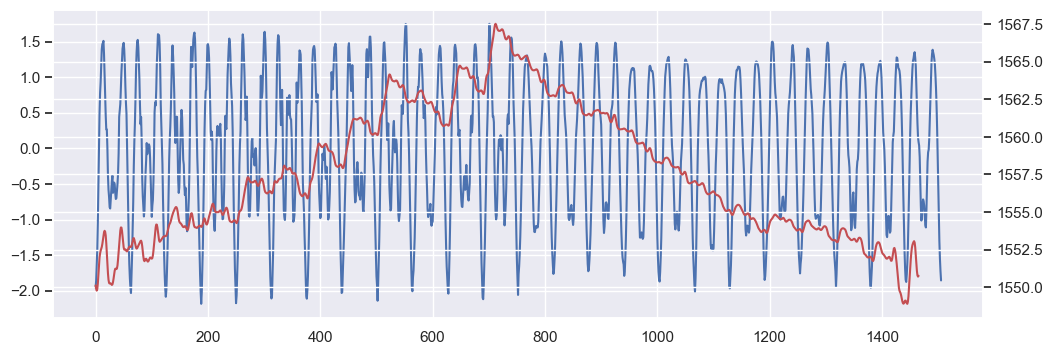

In [36]:
fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(time_series[::])
ax2 = ax1.twinx()
ax2.plot(res_svd_full['ArrowHead'][0]['clasp_scores'][20:-20], 'r')
plt.show()

In [ ]:
# import pickle
# with open('svd_scores.pickle', 'wb') as handle:
#     pickle.dump(res_svd, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('svd_scores.pickle', 'rb') as handle:
    res_svd = pickle.load(handle)
    
with open('knn_scores.pickle', 'rb') as handle:
    res_knn = pickle.load(handle)

In [ ]:
for key in res_knn.keys():
    true_chp = tssb.loc[tssb['dataset'] == key]['change_points'].values[0]
    pred_chp = res_knn[key]
    for i in range(len(pred_chp)):
        diff = np.abs(pred_chp[i] - true_chp[i])
        if abs(diff) > 500:
            print(key)
            print('True:',true_chp)
            print('Pred:',pred_chp)  
            print('='*20)

In [ ]:
res_knn['SonyAIBORobotSurface1']

In [ ]:
tssb.loc[tssb['dataset'] == 'SonyAIBORobotSurface1']['change_points'].values[0]

In [ ]:
diff_list_svd = []
for key in res_svd.keys():
    true_chp = tssb.loc[tssb['dataset'] == key]['change_points'].values[0]
    pred_chp = res_svd[key]
    for i in range(len(pred_chp)):
        diff = np.abs(pred_chp[i] - true_chp[i])
        if abs(diff) < 200:
            diff_list_svd.append(diff)

In [ ]:
diff_list_knn = []
for key in res_knn.keys():
    true_chp = tssb.loc[tssb['dataset'] == key]['change_points'].values[0]
    pred_chp = res_knn[key]
    for i in range(len(pred_chp)):
        diff = np.abs(pred_chp[i] - true_chp[i])
        if abs(diff) < 200:
            diff_list_knn.append(diff)

In [ ]:
plt.figure(figsize=(6,3))
plt.hist(diff_list_knn, bins=20, alpha=0.5, color='r')
plt.hist(diff_list_svd, bins=20, alpha=0.5)
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(6,4), sharey=True)
axs[0].boxplot(diff_list_svd)
axs[1].boxplot(diff_list_knn)

axs[0].set_title('SVD')
axs[1].set_title('KNN')
plt.show()

In [ ]:
line_ds = tssb.loc[tssb['dataset'] == 'InsectWingbeatSound']
line_ts = line_ds['time_series'].values[0]
line_chp = line_ds['change_points'].values[0]
line_chp

In [ ]:
plt.figure(figsize=(8,3))
cur_idx = 0
for i in range(len(line_chp)):
    plt.plot(np.arange(cur_idx,line_chp[i]), line_ts[cur_idx:line_chp[i]])
    cur_idx = line_chp[i]
plt.plot(np.arange(cur_idx,len(line_ts)-1), line_ts[cur_idx:len(line_ts)-1])
plt.show()

In [ ]:
from CLaSP import CLaSP

In [ ]:
cls = CLaSP(window=10, solver='knn')

In [ ]:
cls.fit(line_ts, n_segments=4)

In [ ]:
cls.stack

In [ ]:
numbers = set()
for elem in cls.stack:
    numbers.add(elem['start'])
    numbers.add(elem['stop'])    

In [ ]:
numbers

In [ ]:
plt.imshow(cls.X_dist, cmap='seismic')
plt.show()